# 15. 문자를 읽을 수 있는 딥러닝

`OCR(Optical Character Recognition, 광학 문자 인식)`

<br/>

사람이 문자를 읽기 위해선 문자가 있음을 **인식**하고, 인식한 문자를 **해독**하는 과정을 거친다. 기계도 마찬가지로 문자의 존재를 **Detection**하고, 어떤 문자인지 판독하는 **Recognition** 과정을 거치게 된다.

- [`구글 OCR API`](https://cloud.google.com/vision)

1. 구글의 파이썬 API 인터페이스 모듈 설치
> - pip install --upgrade google-api-python-client
> - pip install google-cloud-vision

2. Google Cloud Vision API 사용
> [링크](https://kimchangheon.tistory.com/166) 참고해서 다운로드한 인증키는 `my_google_api_key.json` 파일로 저장하고, `cloud jupyter`를 열얼 `my_google_api_key.json` 파일을 `~/aiffel/ocr_python` 디렉터리에 업로드 해주기

3. API 사용 테스트

In [6]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [8]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
# path = # [[YOUR IMAGE FILE PATH]]   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-r--r-- 1 root root 2321 Mar  3 06:31 /aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"DIFFICULT
ROA DS
LE AD TO
BE A UTIFUL
DESTIN À TIONS
...
..
...
"

"DIFFICULT"

"ROA"

"DS"

"LE"

"AD"

"TO"

"BE"

"A"

"UTIFUL"

"DESTIN"

"À"

"TIONS"

"..."

".."

"..."
bounds: (894,1229),(895,1305),(874,1305),(873,1229)


구글 API에서는 문자의 영역을 사각형으로 표현하고 우측에 `Block`과 `Paragraph`로 구분해 인식 결과를 나타낸다. 문자 모델은 보통 두 단계로 이루어지는데, 

1. **Text Detection(문자 검출)**: 먼저 입력받은 사진 속에서 문자의 위치를 찾아냄
2. **Text Recognition(문자 인식)**: 찾은 문자 영역으로부터 문자를 읽어내기

> 카카오의 OCR 모델은 먼저 문자가 있는 영역의 정보 (`coord`, `Text Recognition`)를 찾아내고, 각 영역에서 문자를 인식함.

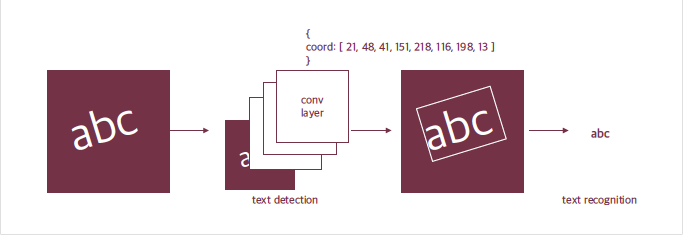

<br/>
(출처: https://brunch.co.kr/@kakao-it/318)

<br/>

위 그림에서는 문자의 영역을 사각형의 네 꼭짓점의 좌푤르 통해 알려주는데, 다른 도형으로도 표현할 수 있을 것이다.
> 논문: [Scene Text Detection with Polygon Offsetting and Border Augmentation](file:///Users/yeon/Downloads/electronics-09-00117.pdf)
>> Bounding Box, Oriented bounding box(돌아간 사각형), Quadrangles(자유로운 사각형), Polygon(다각형) 등

## 1. 딥러닝 문자인식의 시작

MNIST가 딥러닝 데이터셋의 `"hello, world!"`라면, LeNet은 CNN의 `"hello, world!"`라 할 수 있다. LeNet은 1998년 우편번호나 손글씨를 읽기 위해 만들어졌는데, Convolution 레이어와 최종 출력 레이어로 이루어져 있다.

<br/>

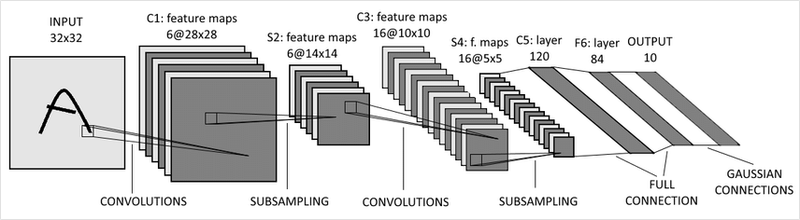

(출처: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

<br/>

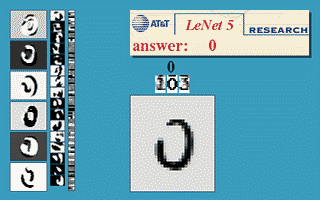
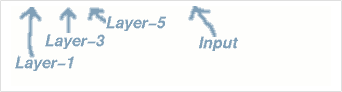

(출처: http://yann.lecun.com/exdb/lenet/stroke-width.html)

<br/>

위 이미지는 입력과 각 layer의 활성화를 시각화한 LeNet의 MNIST 데모 이미지이다. 하지만 이렇게 단순한 분류 모델만으로는 복잡한 결과를 얻을 수 없다. 우리가 인식하기 원하는 사진들은 보통 넓고 복잡한 이미지에 여러 글자가 모여 있어 단순한 분류 모델로 표현이 불가능하다.

## 2. 사진 속 문자 찾아내기 - detection

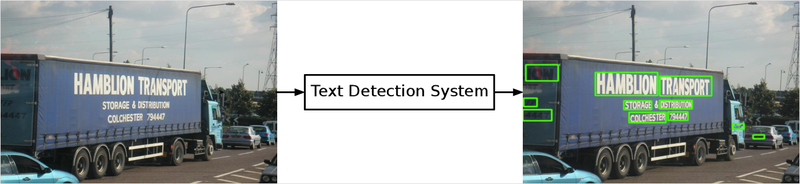

[출처](https://www.semanticscholar.org/paper/End-To-End-Text-Detection-Using-Deep-Learning-Ibrahim/6d8584a900bd77afec55921c2d2d1cb6f1244b25/figure/0)

사진 속 문자를 찾아내는 딥러닝 모델: Object Detection (객체 인식) 방법으로 접근
<br/>

**딥러닝 기반 객체 검출 방법**
- Regression(회귀): 기준으로 하는 박스 대비 문자의 박스가 얼마나 차이 나는지 학습
- Segmentation(세그멘테이션): 픽셀 단위로 해당 픽셀이 문자를 표현하는지 분류하는 문제

## 3. 사진 속 문자 읽어내기 - recognition

사진 속에서 문자를 검출해 내는 검출 모델이 영역을 잘라 주면 그 영역에 어떤 글자가 포함되어 있는지 읽어내는 과정

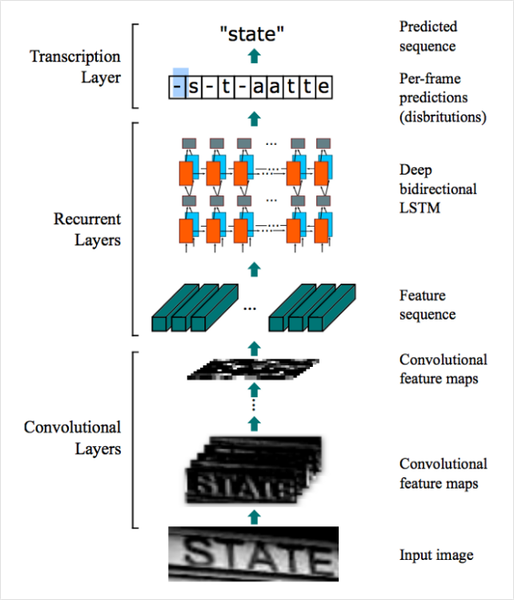

[출처: Ibrahim, Ahmed Sobhy Elnady. End-To-End Text Detection Using Deep Learning. Diss. Virginia Tech, 2017.](https://arxiv.org/abs/1507.05717)

<br/>

위 그림은 ICDAR15라는 OCR 데이터셋에서 단어 단위로 잘린 이미지. 문자 인식 모델은 이렇게 잘린 이미지가 들어오면 이미지 속에 어떤 단어가 포함됐는지 찾아낸다.

> 자연어 처리에서 많은 영감을 받음!
> - 이미지 내의 문자 인식 모델의 가장 기본적 방법 중 하나가 바로 CNN과 RNN을 결합한 CRNN 모델
> - 이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후 스텝 단위의 문자 정보를 RNN으로 인식
> 이렇게 검출 겨로가로부터 인식 모델을 통해 문자를 인식하고 나면 구글 API의 결과처럼 사진 속 영역에 표시를 하고, 그 영역에 어떤 문자가 적혀있는지 알 수 있는 OCR 시스템이 된다.

## 4. keras-ocr 써보기

텐서플로우를 기반으로 모델을 구현해 OCR을 직접 돌려보자.
<br/>

`keras-ocr`: 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줌
> - 검출 모델: `CRAFT`(Character Region Awareness for Text Detection) 사용
> - 인식 모델: `CRNN` 사용

In [9]:
!pip list | grep keras-ocr

keras-ocr                     0.8.8


필요한 라이브러리인 `keras_ocr`과 인식 결과의 시각화를 위한 `matplotlib.pyplot` 불러오기
> `keras_ocr.pipeline.Pipeline()`: 인식을 위한 파이프라인을 생성하는데, 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 됨.
> - 검출기와 인식기를 위한 가중치를 하나씩 불러옴

In [11]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


ResourceExhaustedError: failed to allocate memory [Op:Mul]

> 만들어둔 파이프라인의 `recognize()`에 이미지를 몇 개 넣어줌
> - 이미지 출처: https://unsplash.com/s/photos/text

In [ ]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

> 인식된 결과를 pyplot으로 시각화해보기
> - 내부적으로 `recognize()`는 검출기와 인식기를 두고, 검출기로 bounding box를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정

In [ ]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

> ** keras-ocr은 한글 데이터셋으로는 훈련이 되어 있지 않아, 한글 텍스트의 detection은 recognize 결과가 엉뚱하게 나올 수 있다.

## 5. 테서랙트 써보기

`테서랙트`: 구글에서 후원하는 OCR 오픈소스 라이브러리

#### 1) 테서랙트 설치하기

In [ ]:
# $ sudo apt install tesseract-ocr
# $ sudo apt install libtesseract-dev

#### 2) 테서랙트 파이썬 wrapper 설치하기
`Pytesseract`: OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)
> 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줌

In [ ]:
! pip list | grep pytesseract

### 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)
테서랙트 - 이미지 내의 문자 검출과 인식을 한 번에 할 수 있다.

In [ ]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

> `crop_word_regions()`: 선택한 테스트 이미지를 받아, 문자 검출을 진행한 뒤, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수

> 기본적으로 `pytesseract.image_to_data()`를 사용
> - 파이썬에서 편하게 사용하기 위해 `pytesseract`의 `Output`을 사용해 결괏값의 형식을 딕셔너리(`DICT`) 형식으로 설정해줌
> - 이렇게 인식된 결과는 바운딩 박스의 left, top, widht, height 정보를 가지는데, 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 `PIL(pillow)` 또는 `opencv` 라이브러리를 사용해 잘라(crop)서 `cropped_image_path_list`에 담아 리턴하였다.

In [ ]:
# lang='kor' 에러 방지

# $ sudo apt install tesseract-ocr-kor

#### 4) 테서랙트로 잘린 이미지에서 단어 인식하기

검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 `image_to_string()` 사용

In [ ]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)